In [159]:
from mmdet.apis import init_detector
import torch

import cv2
import numpy as np

import matplotlib.pyplot as plt

In [160]:
# COCO 数据集的 80 类
coco_classes = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
    'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
    'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
    'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
    'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'TV', 'laptop', 'mouse',
    'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# 定义每个尺度的锚框（假设这里使用了YOLOv3常见的锚框大小）
anchors = [
    [(116, 90), (156, 198), (373, 326)],  # 13x13 特征图
    [(30, 61), (62, 45), (59, 119)],     # 26x26 特征图
    [(10, 13), (16, 30), (33, 23)]       # 52x52 特征图
]


In [161]:
def letterbox_image(image, new_shape):
    """
    Resize image with unchanged aspect ratio using padding.
    Args:
    - image (np.ndarray): Input image in HWC format.
    - new_shape (tuple): Desired shape (H, W).

    Returns:
    - padded_img (np.ndarray): Resized and padded image in HWC format.
    """
    h, w = image.shape[:2]
    new_h, new_w = new_shape

    # Calculate the scale and padding
    scale = min(new_w / w, new_h / h)
    scaled_w, scaled_h = int(w * scale), int(h * scale)

    pad_w = (new_w - scaled_w) // 2  # width padding
    pad_h = (new_h - scaled_h) // 2  # height padding

    # Resize the image
    resized_img = cv2.resize(image, (scaled_w, scaled_h), interpolation=cv2.INTER_LINEAR)

    # Create a new image and place the resized image in the center
    padded_img = np.full((new_h, new_w, 3), 128, dtype=np.uint8)  # Using 128 to pad
    padded_img[pad_h:pad_h + scaled_h, pad_w:pad_w + scaled_w, :] = resized_img

    return padded_img

In [162]:
def preprocess(img_path, input_size):
    img_bgr = cv2.imread(img_path)
    img_height, img_width = img_bgr.shape[:2]
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h_scale = input_size[0] / img_height
    w_scale = input_size[1] / img_width
    # print(h_scale, w_scale)
    min_scale = min(h_scale, w_scale)
    img_s_height = round(img_height * min_scale)
    img_s_width = round(img_width * min_scale)
    # print(img_s_height, img_s_width) # 278 416
    # 这里计算32的倍数，然后进行不失真的resize
    img_width_32 = round(img_s_width / 32) * 32  # 13  416
    img_height_32 = round(img_s_height / 32) * 32  # 9  288
    input_img = letterbox_image(img_rgb, (img_height_32, img_width_32)) # img_rgb=(427, 640, 3) =  (416, 288, 3)
    img_tensor = torch.tensor(input_img).permute(2, 0, 1)  # h,w,c-> c ,h, w
    mean=[123.675, 116.28, 103.53]
    std=[58.395, 57.12, 57.375]
    mean_tensor = torch.tensor(mean).float().view(3, 1, 1)
    std_tensor = torch.tensor(std).float().view(3, 1, 1)
    _batch_input = (img_tensor - mean_tensor) / std_tensor
    # print(_batch_input.shape) # torch.Size([3, 416, 288])
    _batch_input = _batch_input.unsqueeze(0)  # [1, 3, 416, 288]
    # print(_batch_input.shape) # [1, 3, 416, 288]
    return _batch_input

In [163]:
def precess_yolo_outputs(outputs, img_size=(288, 416), conf_threshold=0.5, iou_threshold=0.5):
    boxes = []
    confidences = []
    class_ids = []
    
    for i, output in enumerate(outputs[0]):
        batch_size, num_channels, grid_height, grid_width = output.shape
        num_classes = (num_channels // 3) - 5
        scale_output = output.view(batch_size, 3, num_classes + 5, grid_height, grid_width) # 1, 3, 85, 9, 13
        scale_output = scale_output.permute(0, 1, 3, 4, 2).contiguous() # 1, 3, 9, 13, 85
        
        scale_anchors = anchors[i]
        
        for batch in range(batch_size):
            for anchor in range(3):
                for y in range(grid_height):
                    for x in range(grid_width):
                        pred = scale_output[batch, anchor, y, x] # 85
                        
                        obj_conf = torch.sigmoid(pred[4])
                        class_scores = torch.sigmoid(pred[5:])
                        
                        class_score, class_id = torch.max(class_scores, dim=0)
                        confidence = obj_conf * class_score
                        
                        if confidence.item() > conf_threshold:
                            bx = (torch.sigmoid(pred[0]) + x) / grid_width
                            by = (torch.sigmoid(pred[1]) + y) / grid_height
                            
                            anchor_width, anchor_height = scale_anchors[anchor]
                            img_height, img_widht = img_size
                            bw = torch.exp(pred[2]) * anchor_width / img_widht
                            bh = torch.exp(pred[3]) * anchor_height / img_height
                            
                            x1 = int((bx - bw / 2) * img_widht)
                            y1 = int((by - bh / 2) * img_height)
                            x2 = int((bx + bw / 2) * img_widht)
                            y2 = int((by + bh / 2) * img_height)
                            
                            boxes.append([x1, y1, x2 - x1, y2 -y1])
                            confidences.append(float(confidence))
                            class_ids.append(class_id.item())
    
    if len(boxes) > 0:
        boxes = np.array(boxes)
        confidences = np.array(confidences)
        class_ids = np.array(class_ids)
        indices = cv2.dnn.NMSBoxes(boxes.tolist(), confidences.tolist(), conf_threshold, iou_threshold)        
        
        if len(indices) > 0:
            indices = indices.flatten()
            result = [(boxes[i], confidences[i], coco_classes[class_ids[i]]) for i in indices]
        else:
            result = []
    else:
        result = []
    
    return result
                
        

In [164]:
def show_result(img_path, detections, original_size=(427, 640), input_size=(288, 416)):
    if not detections:
        print("No detections found.")
        return
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # 计算宽度和高度的缩放比例
    orig_h, orig_w = original_size
    inp_h, inp_w = input_size
    
    scale_h = orig_h / inp_h
    sclae_w = orig_w / inp_w
    
    for (box, score, class_name) in detections:
        x, y, w, h = box
        x = int(x * sclae_w)
        y = int(y * scale_h)
        w = int(w * sclae_w)
        h = int(h * scale_h)
        
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
        label = f'{class_name}: {score:.2f}'
        cv2.putText(img_rgb, label, (x, y -10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
        

Loads checkpoint by local backend from path: F:/model/mmdet/yolov3/yolov3_mobilenetv2_mstrain-416_300e_coco_20210718_010823-f68a07b3.pth


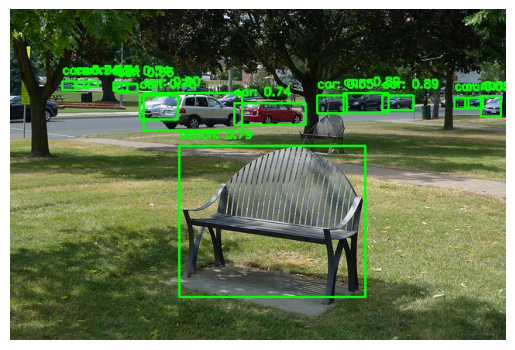

In [165]:
pth_path = "F:/model/mmdet/yolov3/yolov3_mobilenetv2_mstrain-416_300e_coco_20210718_010823-f68a07b3.pth"
cfg_path = "E:/workspace/lanyun_work/openmmlab/mmdetection/configs/yolo/yolov3_mobilenetv2_8xb24-320-300e_coco.py"
model = init_detector(config=cfg_path, checkpoint=pth_path, device='cpu')

img_path = "E:/workspace/lanyun_work/openmmlab/mmdetection/demo/demo.jpg" # 640x427
input_size = (416, 416)
input_img = preprocess(img_path, input_size)

with torch.no_grad():
    outs = model(input_img)
    # outs[0][0].shape torch.Size([1, 255, 9, 13])
    # outs[0][1].shape torch.Size([1, 255, 18, 26])
    # outs[0][2].shape torch.Size([1, 255, 36, 52])

detections = precess_yolo_outputs(outs, img_size=(288, 416), conf_threshold=0.5, iou_threshold=0.5)
show_result(img_path, detections)
